## **Import the TensorFlow library**

This code contains the training for a CNN in which the model learns to recognize the digits. This is different from the other training script because the model learns the digits from 0 to 6. The Idea is to have the digits 7,8,9 for the OL learning to be applied on STM32 Nucleo Board.

Questa parte di codice serve solo per essere compatibile con la OpenMV Cam

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dropout, Dense, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt 
import numpy as np
import random
import os
import csv 
import tempfile

# Absolute path is needed to load libraries 
import sys
ROOT_PATH = os.path.abspath('')
sys.path.append(ROOT_PATH + '/lib')

from lib.frozen_lib import *

ROOT_PATH = os.path.abspath('')
SAVE_MODEL_PATH = ROOT_PATH + "/Models/Bkp_script2"

ORIGINAL_MODEL_PATH = SAVE_MODEL_PATH + "/Original_model/" 
FROZEN_PRUNED_MODEL_PATH = SAVE_MODEL_PATH + "/Frozen_Pruned_model"

2022-10-25 22:05:48.752997: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load MNIST dataset and split in training and test

In [2]:
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

The original dataset shapes are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


Split the train and test dataset in smaller datasets. Separation criterion is if the number is smaller than 6 or not.

In [3]:
train_samples = label_train.shape[0]
test_samples  = label_test.shape[0]

trainLow_samples  = np.sum(np.where(label_train < 6, 1, 0))
testLow_samples = np.sum(np.where(label_test <  6, 1, 0))

# separate in containers data that is lower nad higer than 6
data_low_train   = np.zeros([trainLow_samples,28,28])
label_low_train  = np.zeros(trainLow_samples)
data_high_train  = np.zeros([train_samples-trainLow_samples,28,28])
label_high_train = np.zeros(train_samples-trainLow_samples)

#data_low_test   = np.zeros([testLow_samples,28,28])
#label_low_test  = np.zeros(testLow_samples)
#data_high_test  = np.zeros([test_samples-testLow_samples,28,28])
#label_high_test = np.zeros(test_samples-testLow_samples)

data_low_test   = np.zeros([60,28,28])
label_low_test  = np.zeros(60)
data_high_test  = np.zeros([40,28,28])
label_high_test = np.zeros(40)

j,k = 0,0
for i in range(0,train_samples):  
    if(label_train[i]<6):
        data_low_train[j,:,:] = data_train[i,:,:]
        label_low_train[j]    = label_train[i]
        j+=1
    else:
        data_high_train[k,:,:] = data_train[i,:,:]
        label_high_train[k]    = label_train[i]
        k+=1

#j,k = 0,0
#for i in range(0,test_samples):  
#    if(label_test[i]<6):
#        data_low_test[j,:,:] = data_test[i,:,:]
#        label_low_test[j]    = label_test[i]
#        j+=1
#    else:
#        data_high_test[k,:,:] = data_test[i,:,:]
#        label_high_test[k]    = label_test[i]
#        k+=1

count_0 = 0
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_5 = 0
count_6 = 0
count_7 = 0
count_8 = 0
count_9 = 0

j,k = 0,0
n_elem_low = 10
n_elem_high = 10

for i in range(0,test_samples):
    if(label_test[i]==0 and count_0<n_elem_low):
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        count_0+=1
        j += 1
    if(label_test[i]==1 and count_1<n_elem_low):
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        count_1+=1
        j += 1
    if(label_test[i]==2 and count_2<n_elem_low):
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        count_2+=1
        j += 1
    if(label_test[i]==3 and count_3<n_elem_low):
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        count_3+=1
        j += 1
    if(label_test[i]==4 and count_4<n_elem_low):
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        count_4+=1
        j += 1
    if(label_test[i]==5 and count_5<n_elem_low):
        data_low_test[j,:,:] = data_test[i,:,:]
        label_low_test[j]    = label_test[i]
        count_5+=1
        j += 1
    if(label_test[i]==6 and count_6<n_elem_high):
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        count_6+=1
        k += 1
    if(label_test[i]==7 and count_7<n_elem_high):
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        count_7+=1
        k += 1
    if(label_test[i]==8 and count_8<n_elem_high):
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        count_8+=1
        k += 1
    if(label_test[i]==9 and count_9<n_elem_high):
        data_high_test[k,:,:] = data_test[i,:,:]
        label_high_test[k]    = label_test[i]
        count_9+=1
        k += 1

print('After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:')
print(f'     Train dataset lower than 6 has shape:  {data_low_train.shape}')
print(f'     Train dataset higher than 6 has shape: {data_high_train.shape}')
print()
print(f'     Test dataset lower than 6 has shape:  {data_low_test.shape}')
print(f'     Test dataset higher than 6 has shape: {data_high_test.shape}')

After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:
     Train dataset lower than 6 has shape:  (36017, 28, 28)
     Train dataset higher than 6 has shape: (23983, 28, 28)

     Test dataset lower than 6 has shape:  (60, 28, 28)
     Test dataset higher than 6 has shape: (40, 28, 28)


16
9.0


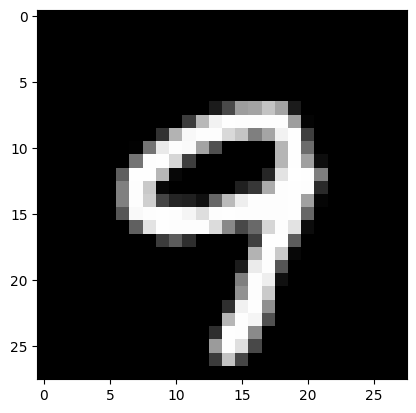

In [4]:
# Randomly check if dataset that I created are filled correctly
num = int(random.uniform(0,20))
print(num)
plt.imshow(data_high_test[num], cmap="gray") # Import the image
print(label_high_test[num])
plt.show() # Plot the image

## **Pre process the data**

In [5]:
# Image dimensions
img_rows, img_cols = 28, 28

# Something I don't know
if K.image_data_format() == 'channels_first':
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], 1, img_rows, img_cols)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], 1, img_rows, img_cols)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], 1, img_rows, img_cols)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], 1, img_rows, img_cols)
    input_shape     = (1, img_rows, img_cols)
else:
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], img_rows, img_cols, 1)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], img_rows, img_cols, 1)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], img_rows, img_cols, 1)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], img_rows, img_cols, 1)
    input_shape     = (img_rows, img_cols, 1)

# Normalization
data_low_train  = data_low_train.astype(np.float32) / 255.0
data_high_train = data_high_train.astype(np.float32) / 255.0
data_low_test   = data_low_test.astype(np.float32) / 255.0
data_high_test  = data_high_test.astype(np.float32) / 255.0

## **BUILD THE MODEL**

In [6]:
TRAIN_MODEL_1 = True
TRAIN_MODEL_2 = False
TRAIN_MODEL_3 = False

In [7]:
batch_size = 32
epochs     = 10 # 40
validation_split = 0.1
optimizer  = "adam"
loss       = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics    = ['accuracy']

In [8]:
if(False):
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(6, activation = "softmax"))

    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    model.summary()

In [9]:
if(TRAIN_MODEL_1):
    model = Sequential()
    
    model.add(Conv2D(8, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(Conv2D(8, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(6,activation='softmax'))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        2336      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                    

2022-10-25 22:05:55.906380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
#if(TRAIN_MODEL_1):
    #tf.keras.utils.plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

In [11]:
# METHOD 2
# This model is a bit larger and should be much more precise in the feature extraction
if(TRAIN_MODEL_2):
    model2 = Sequential()
    model2.add(Conv2D(32, (3, 3), input_shape = input_shape))
    model2.add(Conv2D(32, (3, 3), activation = "relu"))
    model2.add(MaxPooling2D(pool_size = (2, 2)))
    model2.add(Dropout(0.2))
    model2.add(Flatten())
    model2.add(Dense(128, activation = "relu"))
    model2.add(Dropout(0.2))
    model2.add(Dense(6, activation = "softmax"))

    model2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    model2.summary()

In [12]:
if(TRAIN_MODEL_3):

    l = tf.keras.layers # syntax shortcut

    def fire(x, squeeze, expand):
        y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x)
        y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y)
        y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
        return tf.keras.layers.concatenate([y1, y3])

    # this is to make it behave similarly to other Keras layers
    def fire_module(squeeze, expand):
        return lambda x: fire(x, squeeze, expand)

    # usage:
    x = tf.keras.layers.Input(shape=[*input_shape]) # input is 192x192 pixels RGB

    y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    y = tf.keras.layers.Dense(6, activation='softmax')(y)

    model3 = tf.keras.Model(x, y)
    model3.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    model3.summary()

## TRAIN THE MODEL

In [13]:
if(TRAIN_MODEL_1):
    
    labels_prova = keras.utils.to_categorical(label_low_train, 6)

    train_hist = model.fit(data_low_train, label_low_train, epochs = epochs, batch_size = batch_size, validation_split = validation_split)
    
  # Evaluate the model performance
    test_loss, test_acc = model.evaluate(data_low_test, label_low_test)

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

Epoch 1/10


/Users/andrea/Documents/VS Code/MachineLearning/venv/lib/python3.10/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1013/1013 [==============================] - 12s 11ms/step - loss: 0.1477 - accuracy: 0.9524 - val_loss: 0.0368 - val_accuracy: 0.9900
Epoch 2/10
1013/1013 [==============================] - 11s 11ms/step - loss: 0.0427 - accuracy: 0.9874 - val_loss: 0.0258 - val_accuracy: 0.9933
Epoch 3/10
1013/1013 [==============================] - 11s 11ms/step - loss: 0.0293 - accuracy: 0.9906 - val_loss: 0.0258 - val_accuracy: 0.9925
Epoch 4/10
1013/1013 [==============================] - 12s 11ms/step - loss: 0.0241 - accuracy: 0.9920 - val_loss: 0.0201 - val_accuracy: 0.9956
Epoch 5/10
1013/1013 [==============================] - 12s 11ms/step - loss: 0.0184 - accuracy: 0.9943 - val_loss: 0.0198 - val_accuracy: 0.9947
Epoch 6/10
1013/1013 [==============================] - 11s 11ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.0183 - val_accuracy: 0.9956
Epoch 7/10
1013/1013 [==============================] - 12s 11ms/step - loss: 0.0148 - accuracy: 0.9950 - val_loss: 0.0209 - val_accura

In [14]:
if(TRAIN_MODEL_2):

    labels_prova = keras.utils.to_categorical(label_low_train, 6)

    model2.fit(data_low_train, labels_prova, epochs = epochs, batch_size = batch_size, validation_split = validation_split )

    # Evaluate the model performance
    test_loss, test_acc = model2.evaluate(data_low_test, keras.utils.to_categorical(label_low_test, 6))

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

In [15]:
if(TRAIN_MODEL_3):
    
    labels_modified_test = keras.utils.to_categorical(label_low_train, 6)
    
    model3.fit(data_low_train, labels_modified_test, epochs = epochs, batch_size = batch_size, validation_split = validation_split)

    # Evaluate the model performance
    test_loss, test_acc = model3.evaluate(data_low_test, keras.utils.to_categorical(label_low_test, 6))

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

## TEST THE MODEL

function for generating a bar plot htat shows the accuracy of the model for each class

In [16]:
#confusion_matrix = testing(data_low_test, label_low_test, model)
#hostiry_training_plot(train_hist)
#plot_Accuracy(confusion_matrix)
#plot_ConfusionMatrix(confusion_matrix)
#plot_Table(confusion_matrix)

In [17]:
if(TRAIN_MODEL_1):
    model_test = model
elif(TRAIN_MODEL_2):
    model_test = model2
elif(TRAIN_MODEL_3):
    model_test = model3

Il prossimo blocco non è necessario, restituisce errore per le lunghezze diverse di data_low_test e lables_modified_test. Anche mettondole uguali ancora si lamenta.

In [18]:
# tensorflow evaluation on the test dataset
#results = model_test.evaluate(data_low_test,labels_modified_test, batch_size=128)
#print("test loss, test acc:", results)

In [19]:
predictions = model_test.predict(data_low_test)   # Make prediction of entire dataset

2/2 [==============================] - 0s 4ms/step


In [20]:
num = int(random.uniform(0,data_low_test.shape[0]))
print("Prediction = " , np.argmax(predictions[num]))
print("True label = " , label_low_test[num])

Prediction =  2
True label =  2.0


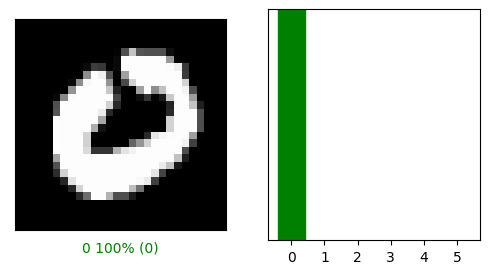

In [21]:
num = int(random.uniform(0, predictions.shape[0]))

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)

plot_image(num, predictions[num], label_low_test, data_low_test)
plt.subplot(1,2,2)

plot_value_array(num, predictions[num], label_low_test)
plt.show()

## **SAVE ORIGINAL MODEL AND FROZEN MODEL**

In [22]:


print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Save ORIGINAL MODEL as mnist_cnn.h5')
model_test.save(ORIGINAL_MODEL_PATH + "mnist_cnn.h5")
save_summary_model(model_test, ORIGINAL_MODEL_PATH, 0, "original")

Test loss: 0.00018170637486036867
Test accuracy: 1.0
Save ORIGINAL MODEL as mnist_cnn.h5


Now create the frozen model version for the one just saved. Which means just to cut away the last layer and save the model without the kast kayer. This should be instead saved in a txt/library file.

### SAVE THE FROZEN MODEL

In [23]:
# CREATE AND SAVE THE FROZEN MODEL
frozen_model = keras.models.Sequential(model_test.layers[:-1])
frozen_model.summary()
frozen_model.compile()

FROZEN_MODEL_PATH = SAVE_MODEL_PATH + "/Frozen_model/"

print('Save FROZEN MODEL model as mnist_cnn.h5')
frozen_model.save(FROZEN_MODEL_PATH + "mnist_cnn.h5")
save_summary_model(frozen_model, FROZEN_MODEL_PATH, 1, "frozen")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        2336      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                  

Now save also the last layer weights in a txt file, this will later be used in the OpenMV camera for loading the weights that have been already trained. (ll = last layer)

In [35]:
ll_weights = np.array(model_test.layers[-1].get_weights()[0])   # get last layer weights from TF model
ll_biases  = np.array(model_test.layers[-1].get_weights()[1])   # get last layer biases from TF model
print(f'The shape of the last layer weights is: {ll_weights.shape}')
print(f'The shape of the last layer biases is: {ll_biases.shape}')


# -------- WEIGHTS
# NB: the filof weights is separated in smaller rows (338 float values on each row)
# thjis is done in order to make it easier for the OpenMV camera to load each line (memory problems)
with open(FROZEN_MODEL_PATH + 'll_weights.txt', 'w') as new_file:

    for j in range(0, ll_weights.shape[1]):
        for i in range(0, ll_weights.shape[0]): 
            if(i%338==0 and i!= 0 and i != ll_weights.shape[0]-1):
                new_file.write('\n')
                
            new_file.write(str(ll_weights[i,j]))
            
            if(i == ll_weights.shape[0]-1):
                new_file.write('\n')
            elif((i+1)%338 == 0):
                dummy = 0
            else:
                new_file.write(',')

new_file.close()


# -------- BIASES
with open(FROZEN_MODEL_PATH + 'll_biases.txt', 'w') as new_file:

    for i in range(0, ll_biases.shape[0]):     
        new_file.write(str(ll_biases[i])) 
        if(i!=ll_biases.shape[0]-1):
            new_file.write(',')
new_file.close()

The shape of the last layer weights is: (512, 6)
The shape of the last layer biases is: (6,)


# Pruning

In [36]:
# Install needed optimization toolkit
from tensorflow.keras.models import load_model
import tensorflow_model_optimization as tfmot

In [37]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after n epochs.
batch_size = 32
epochs = 5
validation_split = 0.1  # 10% of training set will be used for validation set. 

num_images = data_low_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}


model_for_pruning = prune_low_magnitude(model_test, **pruning_params)

# `prune_low_magnitude` requires a recompile.

# Select appropriate optimizer
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 26, 26, 8)        154       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_conv2d_  (None, 24, 24, 8)        1162      
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 12, 12, 8)        1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 10, 10, 32)       4642      
 2 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv2d_  (None, 8, 8, 32)         1

In [38]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(data_low_train, label_low_train,
                    batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=callbacks)

Epoch 1/5


/Users/andrea/Documents/VS Code/MachineLearning/venv/lib/python3.10/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1013/1013 [==============================] - 16s 13ms/step - loss: 0.0104 - accuracy: 0.9965 - val_loss: 0.0194 - val_accuracy: 0.9964
Epoch 2/5
1013/1013 [==============================] - 13s 12ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0196 - val_accuracy: 0.9964
Epoch 3/5
1013/1013 [==============================] - 13s 13ms/step - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0.0220 - val_accuracy: 0.9961
Epoch 4/5
1013/1013 [==============================] - 13s 13ms/step - loss: 0.0066 - accuracy: 0.9976 - val_loss: 0.0212 - val_accuracy: 0.9969
Epoch 5/5
1013/1013 [==============================] - 13s 13ms/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.0225 - val_accuracy: 0.9969


In [29]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(data_low_test, label_low_test, verbose=0)

print('Original test accuracy: ', test_acc)
print('Pruned test accuracy:   ', model_for_pruning_accuracy)

Original test accuracy:  1.0
Pruned test accuracy:    1.0


In [39]:
# First, create a compressible model for TensorFlow

PRUNED_MODEL_PATH = SAVE_MODEL_PATH + "/Pruned_model"


model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.save(PRUNED_MODEL_PATH + '/OMV_Pruned_cnn.h5', include_optimizer=False)

In [40]:
# Then, create a compressible model for TFLite

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

with open(PRUNED_MODEL_PATH + '/OMV_Pruned_cnn.tflite', 'wb') as f:
    f.write(pruned_tflite_model)

INFO:tensorflow:Assets written to: /var/folders/48/lcqkmdxs143dt92dvrnfr3nh0000gn/T/tmpz5w8eq2m/assets


INFO:tensorflow:Assets written to: /var/folders/48/lcqkmdxs143dt92dvrnfr3nh0000gn/T/tmpz5w8eq2m/assets
2022-10-25 22:11:59.273124: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-25 22:11:59.273143: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-25 22:11:59.273275: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/48/lcqkmdxs143dt92dvrnfr3nh0000gn/T/tmpz5w8eq2m
2022-10-25 22:11:59.275564: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-25 22:11:59.275582: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/48/lcqkmdxs143dt92dvrnfr3nh0000gn/T/tmpz5w8eq2m
2022-10-25 22:11:59.283855: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-25 22:11:59.316098: I tensorflow/cc/saved_model/loader.cc:213] Running initialization

In [41]:
def get_gzipped_model_size(file):
    # Returns size of gzipped model, in bytes.
    import os
    import zipfile

    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)

    return os.path.getsize(zipped_file)

In [42]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(FROZEN_MODEL_PATH + "mnist_cnn.h5")))
print("Size of gzipped pruned Keras model  : %.2f bytes" % (get_gzipped_model_size(PRUNED_MODEL_PATH + '/OMV_Pruned_cnn.h5')))
print("Size of gzipped pruned TFlite model : %.2f bytes" % (get_gzipped_model_size(PRUNED_MODEL_PATH + '/OMV_Pruned_cnn.tflite')))

Size of gzipped baseline Keras model: 48555.00 bytes
Size of gzipped pruned Keras model  : 21449.00 bytes
Size of gzipped pruned TFlite model : 19912.00 bytes


In [44]:
frozen_pruned_model = keras.models.Sequential(model_for_pruning.layers[:-1])
frozen_pruned_model.summary()
frozen_pruned_model.compile()

print('Save FROZEN PRUNED MODEL model as OMV_Frozen_pruned_cnn.h5')
frozen_pruned_model.save(FROZEN_PRUNED_MODEL_PATH + "OMV_Frozen_pruned_cnn.h5")
save_summary_model(frozen_pruned_model, FROZEN_PRUNED_MODEL_PATH, 1, "frozen"), 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 26, 26, 8)        154       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_conv2d_  (None, 24, 24, 8)        1162      
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 12, 12, 8)        1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 10, 10, 32)       4642      
 2 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv2d_  (None, 8, 8, 32)        

(None,)

Tflite frozen pruned

In [45]:
model_for_export2 = tfmot.sparsity.keras.strip_pruning(frozen_pruned_model)
model_for_export2.save(PRUNED_MODEL_PATH + '/OMV_Frozen_pruned_cnn.h5', include_optimizer=False)

In [46]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export2)
pruned_tflite_fmodel = converter.convert()

with open(PRUNED_MODEL_PATH + '/OMV_Pruned_cnn.tflite', 'wb') as f:
    f.write(pruned_tflite_fmodel)

INFO:tensorflow:Assets written to: /var/folders/48/lcqkmdxs143dt92dvrnfr3nh0000gn/T/tmp_3mur6ie/assets


INFO:tensorflow:Assets written to: /var/folders/48/lcqkmdxs143dt92dvrnfr3nh0000gn/T/tmp_3mur6ie/assets
2022-10-25 22:12:41.564670: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-25 22:12:41.564687: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-25 22:12:41.564853: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/48/lcqkmdxs143dt92dvrnfr3nh0000gn/T/tmp_3mur6ie
2022-10-25 22:12:41.566887: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-25 22:12:41.566905: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/48/lcqkmdxs143dt92dvrnfr3nh0000gn/T/tmp_3mur6ie
2022-10-25 22:12:41.572795: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-25 22:12:41.621208: I tensorflow/cc/saved_model/loader.cc:213] Running initialization

# FEATURE EXTRACTION FOR CLUSTERING

Pruned

In [47]:
data_test = np.concatenate((data_low_test, data_high_test))
label_test = np.concatenate((label_low_test, label_high_test))
features = frozen_pruned_model.predict(data_test)

4/4 [==============================] - 0s 3ms/step


In [48]:
count = 0

for i in range(0, len(features[:,1])):
  for j in range(0, len(features[1,:])):
    if features[i,j] == 0:
      count +=1

print(count/len(features[:,1])/len(features[1,:])*100)

64.837890625


In [49]:
np.savetxt(FROZEN_PRUNED_MODEL_PATH +'/'+'ll_features_p_10.txt',features, fmt='%.3f')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/andrea/Documents/VS Code/MachineLearning/Models/Bkp_script2/Frozen_Pruned_model/ll_features_p_10.txt'

In [50]:
with open(FROZEN_PRUNED_MODEL_PATH +'/'+'ll_features_p_10.txt', 'w') as new_file:

    for i in range(0, features.shape[0]):
        for j in range(0, features.shape[1]): 
            if features[i,j] != 0:
              str1 = '%.3f '%features[i,j]
            else:
              str1 = '0 '

            new_file.write(str1)
            
        new_file.write('\n')     

new_file.close()

np.savetxt(FROZEN_PRUNED_MODEL_PATH +'/'+'ll_labels_features_p_10.txt',label_test, fmt='%1d')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/andrea/Documents/VS Code/MachineLearning/Models/Bkp_script2/Frozen_Pruned_model/ll_features_p_10.txt'

Original

In [51]:
features = frozen_model.predict(data_test)

4/4 [==============================] - 0s 3ms/step


In [52]:
np.savetxt(ORIGINAL_MODEL_PATH +'/'+'ll_features_10.txt',features, fmt='%.3f')

In [53]:
with open(ORIGINAL_MODEL_PATH +'/'+'ll_features_10.txt', 'w') as new_file:

    for i in range(0, features.shape[0]):
        for j in range(0, features.shape[1]): 
            if features[i,j] != 0:
              str1 = '%.3f '%features[i,j]
            else:
              str1 = '0 '

            new_file.write(str1)
            
        new_file.write('\n')     

new_file.close()

np.savetxt(ORIGINAL_MODEL_PATH +'/'+'ll_labels_features_10.txt',label_test, fmt='%1d')